In [1]:
%load_ext autoreload
%autoreload 2

In [28]:
from __init__ import *
import numpy as np
from export.saver import read_pickle
from helpers.layout import Layout
from helpers.graph_helpers import *
from helpers.helpers import sort_and_group_objects
from typing import Dict
from domains.domain import Domain
from helpers.directions import get_axis, get_opposite_axis, Direction
from placement2.arrange import *
from placement2.place import *
from copy import copy, deepcopy
from icecream import ic
from visuals.plotter import plot_general
from itertools import product
from fixes.reporter import Reporter
from new_solutions.selection import Cook
from domains.range import Range

from fixes.problem_types.overlap_id import create_overlap_problems

In [3]:
layout: Layout = read_pickle("1001_amber_c_ag")
G = layout.graph
domains = layout.domains

In [4]:
arr = create_arrangement(layout)
darr = create_domains_arr(arr, layout.domains)
darr1 = place_nodes(darr)

arrange> NORTH EAST node added when processing 2: ['corridor']
arrange> NORTH EAST node added when processing 3: ['corridor']


In [5]:
doms = create_new_domains(darr1)
doms

{'m_bed': Domain(m_bed, x=[0.00-2.13], y=[-2.45-0.00]),
 'bed1': Domain(bed1, x=[2.13-3.94], y=[-2.45-0.00]),
 'm_closet': Domain(m_closet, x=[0.00-1.47], y=[-3.33--2.45]),
 'transit': Domain(transit, x=[1.47-2.62], y=[-3.41--2.45]),
 'bed1_closet': Domain(bed1_closet, x=[2.62-3.77], y=[-2.82--2.45]),
 'm_bath': Domain(m_bath, x=[0.00-1.61], y=[-4.57--3.33]),
 'corridor': Domain(corridor, x=[1.61-2.06], y=[-6.12--3.41]),
 'linen': Domain(linen, x=[2.06-2.63], y=[-3.80--3.41]),
 'laundry': Domain(laundry, x=[2.63-3.78], y=[-3.91--2.82]),
 'bath': Domain(bath, x=[0.00-1.58], y=[-5.50--4.57]),
 'den': Domain(den, x=[2.06-3.87], y=[-5.96--3.91]),
 'kitchen': Domain(kitchen, x=[0.00-1.47], y=[-8.17--5.50]),
 'dining': Domain(dining, x=[1.47-3.01], y=[-8.56--5.96]),
 'den_closet': Domain(den_closet, x=[3.01-3.81], y=[-6.32--5.96]),
 'living': Domain(living, x=[0.00-3.16], y=[-10.59--8.17])}

In [6]:
lout = create_placement_and_update_layout(layout)

arrange> NORTH EAST node added when processing 2: ['corridor']
arrange> NORTH EAST node added when processing 3: ['corridor']


In [7]:
plot_general(lout.domains)

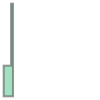

In [8]:
from fixes.problem_types.hole_id import find_holes


find_holes(list(lout.shapes.values()))[2]

In [9]:
a = Domain.create_domain([0, 1.58, -5.50, -4.57], "bath")
b = Domain.create_domain([1.47, 1.61, -5.96, -4.57], "hole")

In [10]:
(a.y, b.y)

([-5.50--4.57], [-5.96--4.57])

In [11]:
a.y.compare_ranges(b.y)

(Lesser=None, Greater=None)

In [12]:
a.compare_domains(b)

N=None 
 S=None 
 E=None 
 W=None

In [13]:
re = Reporter(lout)
re.run()
re.problems

[Problem(ix=1, HOLE, ['corridor', 'den', 'linen', 'laundry'], resolved=False,  n_actions=4,
 Problem(ix=2, HOLE, ['kitchen', 'bath', 'corridor', 'm_bath', 'dining'], resolved=False,  n_actions=4,
 Problem(ix=3, OVERLAP, ['dining', 'corridor'], resolved=False,  n_actions=2,
 Problem(ix=4, HOLE, ['transit', 'linen', 'laundry', 'bed1_closet'], resolved=False,  n_actions=4,
 Problem(ix=5, OVERLAP, ['living', 'dining'], resolved=False,  n_actions=2,
 Problem(ix=6, SIDE_HOLE, ['living', 'den_closet'], resolved=False,  n_actions=2]

In [14]:
c = Cook(re)

initializing.. 0
running again -> 1
problem being studied: -> Problem(ix=1, HOLE, ['corridor', 'den', 'linen', 'laundry'], resolved=False,  n_actions=4
next best layout linen-STRETCH-for-HOLE near ['corridor', 'den']5-PS:7.98-S:6.49


In [26]:
c.bl_hist

[node: linen, action: STRETCH, summary: Counter({'HOLE': 2, 'OVERLAP': 2, 'SIDE_HOLE': 1}), # unres probs: 5,
 node: corridor, action: SQUEEZE, summary: Counter({'HOLE': 2, 'OVERLAP': 1, 'SIDE_HOLE': 1}), # unres probs: 4,
 node: dining, action: SQUEEZE, summary: Counter({'HOLE': 2, 'SIDE_HOLE': 1}), # unres probs: 3,
 node: den_closet, action: STRETCH, summary: Counter({'HOLE': 2}), # unres probs: 2,
 node: transit, action: STRETCH, summary: Counter({'HOLE': 1, 'OVERLAP': 1}), # unres probs: 2,
 node: bed1_closet, action: PUSH, summary: Counter({'HOLE': 1}), # unres probs: 1,
 node: kitchen, action: PULL, summary: Counter({'OVERLAP': 1, 'HOLE': 1}), # unres probs: 2]

In [40]:
plot_general(c.bl_hist[-1].layout.domains)

In [33]:
p = create_overlap_problems(c.bl_hist[-1].layout)
p[0].action_details[1].action_types

[<ActionType.PUSH: 1>, <ActionType.SQUEEZE: 4>]

In [38]:
c.run_again()


running again -> 9
problem being studied: -> Problem(ix=3, HOLE, ['kitchen', 'bath', 'corridor', 'm_bath'], resolved=False,  n_actions=4
next best layout bath-PULL-for-HOLE near ['kitchen', 'bath']0-PS:0.03-S:0.01


In [39]:
f = c.plot_all()

len sols = 9. Len indices = 9
